# Case Study 1 (Working file)

### Introduction

Knowing the location of business-critical machiney and/or workers is essential to optimize productivity for organizations that live and die by shipping times, workflow prioritization, deliverable timelines, and cost minimization. Real-time location systems (RTLS) have enabled some business to be in a position to monitor their assets through the production cycle. 

In this case study, we are evaluating the use of RTLS over wifi for an organization. Specifically, our authors (Nolan and Lang) posit that by distributing various wifi-enabled RTLS devices across the facility to assets, one might be able to use clustering methods to ascertain the predicted position of those assets based on past behavior. 

## Imports

In [49]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans 
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

## Create DataFrame

In [33]:
column_names = ['time', 'scanMac', 'posX', 'posY', 'posZ', 'orientation', 'mac', 'signal', 'channel', 'type']

lines = None
with open('../Data/offline.final.trace.txt', 'r') as file:
    lines = file.readlines()
    file.close()

instances = [] # will hold final data for dataframe

for line in lines:
    
    # strip "\n" from line
    line = line.rstrip('\n')
    
    # skip if comment
    if line[0] == '#':
        continue

    base = [] # [t, id, x, y, z, degree]
    rows = [] # base + [mac, signal, channel, type]

    for keyvalue in line.split(';'):
        key, value = keyvalue.split('=')

        if key in ['t', 'id', 'degree']:
            base.append(value)
        elif key == 'pos':
            # pos (x, y, z)
            base += value.split(',')
        else:
            # mac addresses and metrics (signal, channel, type)
            row = base.copy()
            row.append(key)
            row += value.split(',')
            rows.append(row)
    
    instances += rows

df = pd.DataFrame(instances, columns = column_names)

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1181628 entries, 0 to 1181627
Data columns (total 10 columns):
time           1181628 non-null object
scanMac        1181628 non-null object
posX           1181628 non-null object
posY           1181628 non-null object
posZ           1181628 non-null object
orientation    1181628 non-null object
mac            1181628 non-null object
signal         1181628 non-null object
channel        1181628 non-null object
type           1181628 non-null object
dtypes: object(10)
memory usage: 90.2+ MB
None


,time,scanMac,posX,posY,posZ,orientation,mac,signal,channel,type
0,1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:14:bf:b1:97:8a,-38,2437000000,3
1,1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:14:bf:b1:97:90,-56,2427000000,3
2,1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:0f:a3:39:e1:c0,-53,2462000000,3
3,1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:14:bf:b1:97:8d,-65,2442000000,3
4,1139643118358,00:02:2D:21:0F:33,0.0,0.0,0.0,0.0,00:14:bf:b1:97:81,-65,2422000000,3


In [35]:
column_names = ['time', 'scanMac', 'posX', 'posY', 'posZ', 'orientation', 'mac', 'signal', 'channel', 'type']

lines = None
with open('../Data/online.final.trace.txt', 'r') as file:
    lines = file.readlines()
    file.close()

instances = [] # will hold final data for dataframe

for line in lines:
    
    # strip "\n" from line
    line = line.rstrip('\n')
    
    # skip if comment
    if line[0] == '#':
        continue

    base = [] # [t, id, x, y, z, degree]
    rows = [] # base + [mac, signal, channel, type]

    for keyvalue in line.split(';'):
        key, value = keyvalue.split('=')

        if key in ['t', 'id', 'degree']:
            base.append(value)
        elif key == 'pos':
            # pos (x, y, z)
            base += value.split(',')
        else:
            # mac addresses and metrics (signal, channel, type)
            row = base.copy()
            row.append(key)
            row += value.split(',')
            rows.append(row)
    
    instances += rows

df_online = pd.DataFrame(instances, columns = column_names)

print(df_online.info())
df_online.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53303 entries, 0 to 53302
Data columns (total 10 columns):
time           53303 non-null object
scanMac        53303 non-null object
posX           53303 non-null object
posY           53303 non-null object
posZ           53303 non-null object
orientation    53303 non-null object
mac            53303 non-null object
signal         53303 non-null object
channel        53303 non-null object
type           53303 non-null object
dtypes: object(10)
memory usage: 4.1+ MB
None


,time,scanMac,posX,posY,posZ,orientation,mac,signal,channel,type
0,1139692477303,00:02:2D:21:0F:33,0.0,0.05,0.0,130.5,00:14:bf:b1:97:8a,-43,2437000000,3
1,1139692477303,00:02:2D:21:0F:33,0.0,0.05,0.0,130.5,00:0f:a3:39:e1:c0,-52,2462000000,3
2,1139692477303,00:02:2D:21:0F:33,0.0,0.05,0.0,130.5,00:14:bf:3b:c7:c6,-62,2432000000,3
3,1139692477303,00:02:2D:21:0F:33,0.0,0.05,0.0,130.5,00:14:bf:b1:97:81,-58,2422000000,3
4,1139692477303,00:02:2D:21:0F:33,0.0,0.05,0.0,130.5,00:14:bf:b1:97:8d,-62,2442000000,3


## Exploratory Data Analysis (EDA)

In [36]:
df['mac'].value_counts()

00:0f:a3:39:e1:c0    145862
00:0f:a3:39:dd:cd    145619
00:14:bf:b1:97:8a    132962
00:14:bf:3b:c7:c6    126529
00:14:bf:b1:97:90    122315
00:14:bf:b1:97:8d    121325
00:14:bf:b1:97:81    120339
02:00:42:55:31:00    103887
02:64:fb:68:52:e6     50852
00:0f:a3:39:e0:4b     43508
02:2e:58:22:f1:ac     25112
00:0f:a3:39:e2:10     19162
02:37:fd:3b:54:b5      8732
02:b7:00:bb:a9:35      7602
02:5c:e0:50:49:de      6997
00:04:0e:5c:23:fc       418
00:30:bd:f8:7f:c5       301
00:e0:63:82:8b:a9       103
02:42:1c:4e:b5:c0         1
02:0a:3d:06:94:88         1
02:4f:99:43:30:cd         1
Name: mac, dtype: int64

In [45]:
#one hot encoding offline
cols_to_transform = ['mac','scanMac','channel']

df2 = pd.get_dummies(df, columns = cols_to_transform)

#one hot encoding online
#cols_to_transform = ['mac','scanMac','channel']

#df_online2 = pd.get_dummies(df_online, columns = cols_to_transform)

In [46]:
df2.head()

,time,posX,posY,posZ,orientation,signal,type,mac_00:04:0e:5c:23:fc,mac_00:0f:a3:39:dd:cd,mac_00:0f:a3:39:e0:4b,...,channel_2412000000,channel_2422000000,channel_2427000000,channel_2432000000,channel_2437000000,channel_2442000000,channel_2447000000,channel_2457000000,channel_2462000000,channel_2472000000
0,1139643118358,0.0,0.0,0.0,0.0,-38,3,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,1139643118358,0.0,0.0,0.0,0.0,-56,3,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,1139643118358,0.0,0.0,0.0,0.0,-53,3,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1139643118358,0.0,0.0,0.0,0.0,-65,3,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,1139643118358,0.0,0.0,0.0,0.0,-65,3,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [50]:
# Attributes vs. Label split - Offline data
x = df2.iloc[:, :-1].values
y = df2.iloc[:, 4].values

In [52]:
# Split into test / train on the offline data (assuming we cannot even see the online data)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

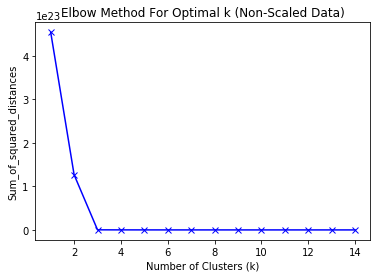

In [39]:
# Create elbow plot for sanity check on number of clusters - unscaled data
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df2)
    Sum_of_squared_distances.append(km.inertia_)
    
# Plot the appropriate k cluster size
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k (Non-Scaled Data)')
plt.show()

In [53]:
# Scale the data - offline
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [47]:
# Scale the data - online
#scaler = StandardScaler()
#scaler.fit(df_online2)

d#f2_scaled_on = scaler.transform(df_online2)
#X_test = scaler.transform(X_test)

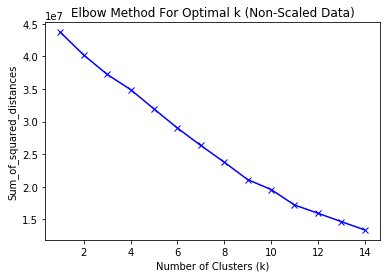

In [48]:
# Create elbow plot for sanity check on number of clusters - scaled data
# Optimal K = 11?
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df2_scaled)
    Sum_of_squared_distances.append(km.inertia_)
    
# Plot the appropriate k cluster size
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k (Non-Scaled Data)')
plt.show()

In [ ]:
# Create KNN plot
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train, y_train)

In [ ]:
y_pred = classifier.predict(X_test)